# Sentiment Analysis on Amazon Food Review

1. [Importing Libraries](#Libraries) 
2. [Scraping the data from website](#scraping)
3. [Data Loading and Wrangling](#loading)
4. [Missing Values and Duplicate Handling](#missing)
5. [Data Visualization](#visualization)
6. [Text Pre-processing](#text_preprocess)
7. [Bag of Words Analysis](#bow_analysis)
8. [Training and Testing](#tnt)
9. [Vectorizing data with different techiniques](#vec)
10.
11.
12.


In [ ]:
# !pip install selenium
# https://www.browserstack.com/guide/web-scraping-using-selenium-python

In [ ]:
# !pip install webdriver_manager

# Importing Libraries <a name='Libraries'></a>

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import codecs
import re
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
from tqdm import tqdm
import datetime
import numpy as np

In [ ]:
def save_csv_file(products_review):
    df = pd.DataFrame(products_review, columns=['product',
    'product_name',
    'review_title',  
    'review_description',
    'rating'])
    
    df.to_csv(f"amazon_products_review.csv", index= False)
    print(f"file saved! at {datetime.datetime.now()}")

In [ ]:
# read the new csv file
df = pd.read_csv('product_id.csv')
df.shape

In [ ]:
# Check for duplicated rows
print("Number of duplicate rows:", df.duplicated().sum())

df[df.duplicated() == True]
df.drop_duplicates(inplace= True, keep='last')

In [ ]:
df.shape

In [ ]:
# Obtain the version of ChromeDriver compatible with the browser being used
driver=webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# Scraping data from amazon <a name='scraping'></a>

In [ ]:
main_url = 'https://www.amazon.com/dp/product-reviews/'
products_review = []

print(f"the process started at {datetime.datetime.now()}")
for product in tqdm(df['ProductId'][25000:35000]):
    try:
        
        new_url = main_url + product
        # creates a WebDriverWait object, which waits for a specified amount of time
        wait = WebDriverWait(driver, 10)
        # navigates the WebDriver instance to a new URL specified by the new_url variable.
        driver.get(new_url)
        # This line retrieves the current URL of the WebDriver instance and stores it in the get_url variable.
        get_url = driver.current_url
        # This line waits until the current URL of the WebDriver instance matches the new_url variable, 
        # using the url_to_be expected condition from the EC (Expected Conditions) module. 
        # Once the condition is met, the script will proceed to the next line of code.
        wait.until(EC.url_to_be(new_url))

        if get_url == new_url:
            page_source = driver.page_source

        soup = BeautifulSoup(page_source,features='html.parser')
        
        # Find the product name element
        product_name_tag = soup.find('a', {'class': 'a-link-normal'})
        product_name = product_name_tag.text if product_name_tag else np.nan

        # find the top positive section
        top_review_positive = soup.find('div', {'class': 'positive-review'})

        if top_review_positive:
            # extrac the positive review's information
            review_title = top_review_positive.find('span', attrs={'data-hook': 'review-title'}).text
            review_description = top_review_positive.find('div', {'class': 'a-row a-spacing-top-mini'}).find('span', {'class': 'a-size-base'}).text
            review_description = review_description.replace('\n', '')
            rating = top_review_positive.find('i', {'class': 'review-rating'}).find('span').text

            # adding to a new product review row
            products_review.append([product, product_name, review_title, review_description, rating])
        else:
            # There are cases in which certain articles do not have Top positive and negative reviews, 
            # in those particular cases we must look in the following segment of reviews and obtain the first one
            reviews = soup.find_all('div', {'data-hook': 'review'})

            for review in reviews[:1]:                
                review_title = review.find('a', {'data-hook': 'review-title'}).text.strip()
                review_description = review.find('span', {'data-hook': 'review-body'}).text.strip()
                rating = review.find('i', {'data-hook': 'review-star-rating'}).text
                
                # adding to a new product review row
                products_review.append([product, product_name, review_title, review_description, rating])

        # find the top negative section
        top_review_negative = soup.find('div', {'class': 'critical-review'})

        if top_review_negative:
            # extrac the negative review's information
            review_title = top_review_negative.find('span', attrs={'data-hook': 'review-title'}).text
            review_description = top_review_negative.find('div', {'class': 'a-row a-spacing-top-mini'}).find('span', {'class': 'a-size-base'}).text
            review_description = review_description.replace('\n', '')
            rating = top_review_negative.find('i', {'class': 'review-rating'}).find('span').text

            # adding to a new product review row
            products_review.append([product, product_name, review_title, review_description, rating])
        
    except:
        continue
        
        
# finally save the .csv file for the scraped data
if products_review:
    save_csv_file(products_review)
else:
    print("There isn't any data to save!")

print(f"the process finished at {datetime.datetime.now()}")

In [ ]:
pip install -U gensim

# Amazon Fine Food Reviews Analysis

[Libraries Uses](#libraries)

# Importing Libraries <a href="libraries"/>

In [137]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Data Loading and Wrangling <a name='loading'></a>

In [7]:
amazon_data=pd.read_csv('final_food_reviews.csv')

In [8]:
amazon_data.head()

Unnamed: 0   ProductId  Score  \
0      114123  B004FELBH8      5   
1       11425  B0002NVKWC      2   
2       88709  B004K0862K      3   
3      562693  B0009YJ4CW      2   
4       56195  B0039ZOZ86      5   

                                             Summary  \
0                  Shatter's Newton's Law Fabulously   
1                     Expensive Mushrooms?  Ehhh....   
2  Better than regular dry milk, but it is NOT as...   
3  treat out in &lt;1 min. devoured in about 5 mi...   
4                                           Perfect!   

                                                Text  
0  Once you get past the shattering of a traditio...  
1  I went for these, when I got a free 30 bucks t...  
2  This is OK, but it does not taste like the REA...  
3  My dog loves the <a href="http://www.amazon.co...  
4  I have looked and looked to find any kind of p...

In [9]:
amazon_data.rename(columns={'Unnamed: 0':'User_ID'}, inplace=True)

In [10]:
amazon_data.head()

User_ID   ProductId  Score  \
0   114123  B004FELBH8      5   
1    11425  B0002NVKWC      2   
2    88709  B004K0862K      3   
3   562693  B0009YJ4CW      2   
4    56195  B0039ZOZ86      5   

                                             Summary  \
0                  Shatter's Newton's Law Fabulously   
1                     Expensive Mushrooms?  Ehhh....   
2  Better than regular dry milk, but it is NOT as...   
3  treat out in &lt;1 min. devoured in about 5 mi...   
4                                           Perfect!   

                                                Text  
0  Once you get past the shattering of a traditio...  
1  I went for these, when I got a free 30 bucks t...  
2  This is OK, but it does not taste like the REA...  
3  My dog loves the <a href="http://www.amazon.co...  
4  I have looked and looked to find any kind of p...

In [11]:
sample=amazon_data['Text'][1]

In [12]:
sam_bi=nltk.bigrams(nltk.word_tokenize(sample))

In [13]:
print(list(sam_bi))

[('I', 'went'), ('went', 'for'), ('for', 'these'), ('these', ','), (',', 'when'), ('when', 'I'), ('I', 'got'), ('got', 'a'), ('a', 'free'), ('free', '30'), ('30', 'bucks'), ('bucks', 'to'), ('to', 'spend'), ('spend', 'with'), ('with', 'a'), ('a', 'new'), ('new', 'Amazon'), ('Amazon', 'Credit'), ('Credit', 'Card'), ('Card', ','), (',', 'and'), ('and', 'Im'), ('Im', 'glad'), ('glad', 'I'), ('I', 'did'), ('did', "n't"), ("n't", 'pay'), ('pay', 'full'), ('full', 'price.'), ('price.', '<'), ('<', 'br'), ('br', '/'), ('/', '>'), ('>', '<'), ('<', 'br'), ('br', '/'), ('/', '>'), ('>', 'I'), ('I', 'was'), ('was', 'in'), ('in', 'the'), ('the', 'process'), ('process', 'of'), ('of', 'creating'), ('creating', 'an'), ('an', 'authentic'), ('authentic', 'Bolognese'), ('Bolognese', 'Meat'), ('Meat', 'Sauce'), ('Sauce', ','), (',', 'and'), ('and', 'I'), ('I', 'wanted'), ('wanted', 'some'), ('some', 'very'), ('very', 'hearty'), ('hearty', 'mushrooms'), ('mushrooms', 'to'), ('to', 'add'), ('add', 'a'), (

In [14]:
amazon_data['Score'].value_counts()

5    72076
1    52268
2    29769
4    16700
3     9070
Name: Score, dtype: int64

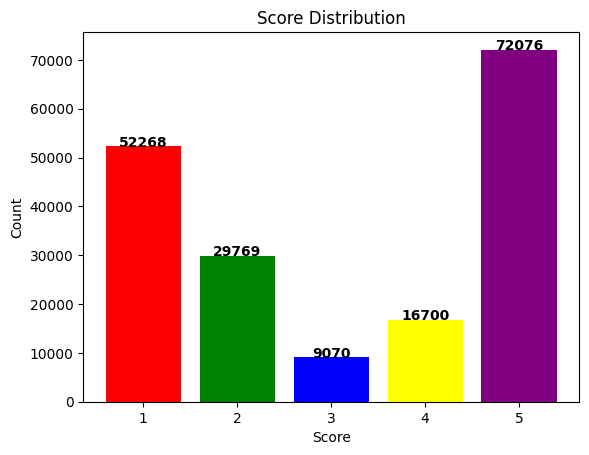

In [15]:
import matplotlib.pyplot as plt

# Define the colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'purple']

# Create a figure and axis object
fig, ax = plt.subplots()

# Create a bar plot using ax.bar()
ax.bar(x=amazon_data['Score'].sort_values().unique(), height=amazon_data['Score'].value_counts().sort_index(), color=colors)

# Add labels to the bars
for i, v in enumerate(amazon_data['Score'].value_counts().sort_index()):
    ax.text(i+1, v + 15, str(v), ha='center', fontweight='bold')

# Set the title and axis labels
ax.set_title('Score Distribution')
ax.set_xlabel('Score')
ax.set_ylabel('Count')

# Show the plot
plt.show()


In [16]:
def define_target(x):
    if x<3:
        return 0
    else:
        return 1

In [17]:
amazon_data['target']=amazon_data['Score'].apply(define_target)

In [18]:
amazon_data.head()

User_ID   ProductId  Score  \
0   114123  B004FELBH8      5   
1    11425  B0002NVKWC      2   
2    88709  B004K0862K      3   
3   562693  B0009YJ4CW      2   
4    56195  B0039ZOZ86      5   

                                             Summary  \
0                  Shatter's Newton's Law Fabulously   
1                     Expensive Mushrooms?  Ehhh....   
2  Better than regular dry milk, but it is NOT as...   
3  treat out in &lt;1 min. devoured in about 5 mi...   
4                                           Perfect!   

                                                Text  target  
0  Once you get past the shattering of a traditio...       1  
1  I went for these, when I got a free 30 bucks t...       0  
2  This is OK, but it does not taste like the REA...       1  
3  My dog loves the <a href="http://www.amazon.co...       0  
4  I have looked and looked to find any kind of p...       1

In [19]:
amazon_data.drop(['Score','User_ID'],axis=1,inplace=True)

In [20]:
amazon_data

ProductId                                            Summary  \
0       B004FELBH8                  Shatter's Newton's Law Fabulously   
1       B0002NVKWC                     Expensive Mushrooms?  Ehhh....   
2       B004K0862K  Better than regular dry milk, but it is NOT as...   
3       B0009YJ4CW  treat out in &lt;1 min. devoured in about 5 mi...   
4       B0039ZOZ86                                           Perfect!   
...            ...                                                ...   
179878  B0039KF3IM                 Yum, yum, yum!! These are awesome!   
179879  B001E5E0IS                                       Taste is off   
179880  B0011EO7WQ            Great Moisturizer, Overpowered by Scent   
179881  B001XSMANI      Same jar at Costco but 16 bucks instead of 22   
179882  B001T4UMM2        Only one of my two dogs liked these, but...   

                                                     Text  target  
0       Once you get past the shattering of a traditio...       1  
1       I went for these, when I got a free 30 bucks t...       0  
2       This is OK, but it does not taste like the REA...       1  
3       My dog loves the <a href="http://www.amazon.co...       0  
4       I have looked and looked to find any kind of p...       1  
...                                                   ...     ...  
179878  I love the original Almondina biscuits and hav...       1  
179879  This tastes bitter and sort of...fishy? The Je...       0  
179880  This product moisturizes very nicely. It goes ...       0  
179881  I bought this online thinking that it will be ...       0  
179882  My rescued 4 year old pit bull absolutely love...       0  

[179883 rows x 4 columns]

# Missing value and duplication handling <a name='missing'></a>

#### checking for any nulls

In [21]:
amazon_data.isnull().sum()

ProductId     0
Summary      25
Text          0
target        0
dtype: int64

In [22]:
amazon_data.dropna(inplace=True)

#### checking for duplicates and dropping them

In [23]:
amazon_data = amazon_data.applymap(lambda x: tuple(x) if isinstance(x, list) else x)
duplicates = amazon_data.duplicated().sum()
print("Number of duplicate rows in amazon_data:", duplicates)


Number of duplicate rows in amazon_data: 399


In [24]:
amazon_data.drop_duplicates(inplace=True)

In [25]:
print("Shape of amazon_data after missing value and duplication handling is:", amazon_data.shape)

Shape of amazon_data after missing value and duplication handling is: (179459, 4)


# Data Visualization   <a name='visualization'></a>

### Exploring unique values of Target column

In [26]:
amazon_data['target'].value_counts()

1    97736
0    81723
Name: target, dtype: int64

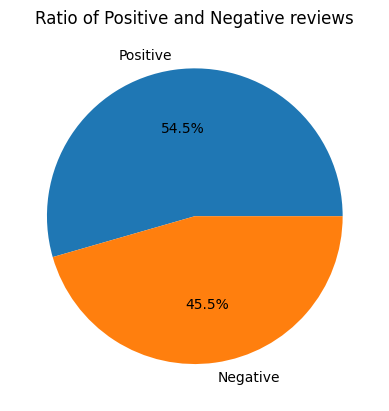

In [27]:
# Count the number of statements for each target
counts = amazon_data['target'].value_counts()

# Create a pie chart
plt.pie(counts.values, labels=['Positive','Negative'], autopct='%1.1f%%')
plt.title('Ratio of Positive and Negative reviews')

# Show the pie chart
plt.show()
# 0 = Negative review 
# 1 = Positive review

Observation: It is clear that we have an imbalenced dataset for classification. So We cannot choose accuracy as a metric. So here we will go with AUC(Area under ROC curve)

What is AUC ROC?

AUC is the area under ROC curve.It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

# Text Preprocessing <a name=text_preprocess></a>

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [28]:
stop=set(stopwords.words('english')) #set of stopwords
sno=SnowballStemmer('english')

In [29]:
def cleanhtml(sentence): #clean html tags
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation
    cleaned=re.sub(r'[^\w\s]','',sentence)
    return cleaned

In [30]:
i=0
positive_words=[]
negative_words=[]
final_string=[]

for sent in amazon_data['Text'].values:
    print(i)
    filtered_sentence=[]
    sent=cleanhtml(sent) #remove html
    for word in sent.split():
        for cleaned_words in cleanpunc(word).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (amazon_data['target'].values)[i] == 1:
                        positive_words.append(s)
                    else:
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = " ".join([word.decode('utf-8') for word in filtered_sentence]) #final string of cleaned words
    final_string.append(str1)
    i+=1
                        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [31]:
final_string[0:3]

['get past shatter tradit annihil stereotyp allow enjoy new offer nabisco packag say crispi cooki that thin crispi round confect scallop edg bit embed fig raisin like tast kaleidoscop swirl tast textur pleas palat even fussi mrsspudman like new newton reserv newton fruit thin satisfi blend crisp chewi sweet over even embellish natur flavor last ingredi list like ingredi real recogniz pronounc bag chemic artifici bag natur flavor natur flavor sound like abund natur',
 'went got free buck spend new amazon credit card glad didnt pay full price process creat authent bolognes meat sauc want hearti mushroom add bit oomph sauc meat onion heavi figur review meati tast mushroom also see price ask local giant eagl groceri store yeah get bargain rip price basic take freezer space order two grade higher grade bigger shroom piec less stem etc retrospect order scrap even dust found big piec stay nasti tough chewi textur even hour cook also extract juic mushroom broth wasnt strong enough bother basic

In [32]:
len(final_string)

179459

In [33]:
amazon_data.shape

(179459, 4)

In [34]:
amazon_data['processed_string']=final_string

In [35]:
amazon_data.head()

ProductId                                            Summary  \
0  B004FELBH8                  Shatter's Newton's Law Fabulously   
1  B0002NVKWC                     Expensive Mushrooms?  Ehhh....   
2  B004K0862K  Better than regular dry milk, but it is NOT as...   
3  B0009YJ4CW  treat out in &lt;1 min. devoured in about 5 mi...   
4  B0039ZOZ86                                           Perfect!   

                                                Text  target  \
0  Once you get past the shattering of a traditio...       1   
1  I went for these, when I got a free 30 bucks t...       0   
2  This is OK, but it does not taste like the REA...       1   
3  My dog loves the <a href="http://www.amazon.co...       0   
4  I have looked and looked to find any kind of p...       1   

                                    processed_string  
0  get past shatter tradit annihil stereotyp allo...  
1  went got free buck spend new amazon credit car...  
2  tast like real thing tast like milk flavor sat...  
3  dog love starmark dayglo everlast fun ball med...  
4  look look find kind potato chip type product s...

In [36]:
amazon_data['processed_string'].head(2)

0    get past shatter tradit annihil stereotyp allo...
1    went got free buck spend new amazon credit car...
Name: processed_string, dtype: object

# Bag of words Analysis <a name=bow_analysis></a>

In [37]:
def get_top_n_words (corpus,n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq=[(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [38]:
common_words = get_top_n_words(amazon_data['processed_string'],20)

<AxesSubplot: title={'center': 'Bar Chart of top 20 words frequency'}, xlabel='Top Words', ylabel='Count'>

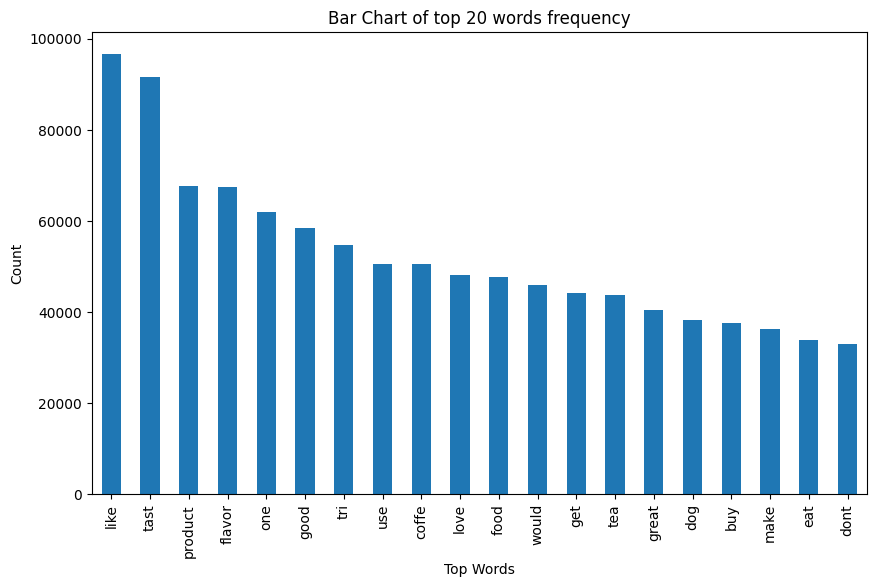

In [39]:
df1= pd.DataFrame(common_words,columns=['Review','Count'])
df1.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(kind='bar', figsize=(10,6),xlabel="Top Words",ylabel="Count", title='Bar Chart of top 20 words frequency')

In [40]:
#count_vect=CountVectorizer()
#final_counts=count_vect.fit_transform(amazon_data['processed_string'].values)
#final_counts

In [41]:
#type(final_counts)   

In [42]:
#final_counts.get_shape()

In [43]:
freq_positive=nltk.FreqDist(positive_words)
freq_negative=nltk.FreqDist(negative_words)

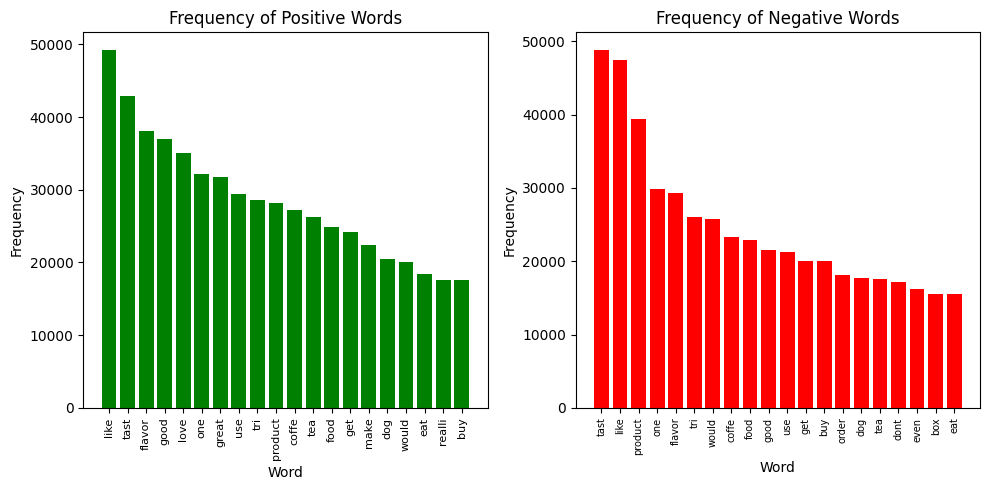

In [44]:
# Get the top 10 most common positive words
top_positive_words = freq_positive.most_common(20)
# Get the top 10 most common negative words
top_negative_words = freq_negative.most_common(20)

# Create a figure and axis object with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Plot the frequency of positive words in the first subplot
ax1.bar([word[0] for word in top_positive_words], [word[1] for word in top_positive_words], color='green')
ax1.set_title('Frequency of Positive Words')
ax1.set_xlabel('Word')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', labelsize=8, rotation = 90) # set the xtick font size to 8


# Plot the frequency of negative words in the second subplot
ax2.bar([word[0] for word in top_negative_words], [word[1] for word in top_negative_words], color='red')
ax2.set_title('Frequency of Negative Words')
ax2.set_xlabel('Word')
ax2.set_ylabel('Frequency')
ax2.tick_params(axis='x', labelsize=7, rotation = 90) # set the xtick font size to 8

# Adjust the layout of the subplots
fig.tight_layout()


# Show the plot
plt.show()


Observation:- From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc.

So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [45]:
amazon_data.head()

ProductId                                            Summary  \
0  B004FELBH8                  Shatter's Newton's Law Fabulously   
1  B0002NVKWC                     Expensive Mushrooms?  Ehhh....   
2  B004K0862K  Better than regular dry milk, but it is NOT as...   
3  B0009YJ4CW  treat out in &lt;1 min. devoured in about 5 mi...   
4  B0039ZOZ86                                           Perfect!   

                                                Text  target  \
0  Once you get past the shattering of a traditio...       1   
1  I went for these, when I got a free 30 bucks t...       0   
2  This is OK, but it does not taste like the REA...       1   
3  My dog loves the <a href="http://www.amazon.co...       0   
4  I have looked and looked to find any kind of p...       1   

                                    processed_string  
0  get past shatter tradit annihil stereotyp allo...  
1  went got free buck spend new amazon credit car...  
2  tast like real thing tast like milk flavor sat...  
3  dog love starmark dayglo everlast fun ball med...  
4  look look find kind potato chip type product s...

In [46]:
positive_bigrams=[]
negative_bigrams=[]

i=0

for sent in amazon_data['Text'].values:
    print(i)
    filtered_sentence=[]
    sent=cleanhtml(sent) #remove html
    tokens=nltk.word_tokenize(sent)
    bigrams=nltk.bigrams(tokens)
    if (amazon_data['target'].values)[i]==1:
        positive_bigrams.append(list(bigrams))
    else:
        negative_bigrams.append(list(bigrams))
    i+=1
           

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [47]:
tu=positive_bigrams[0]

In [48]:
for tup in positive_bigrams:
    result=tup

In [49]:
positive_bigrams[0:5]

[[('Once', 'you'),
  ('you', 'get'),
  ('get', 'past'),
  ('past', 'the'),
  ('the', 'shattering'),
  ('shattering', 'of'),
  ('of', 'a'),
  ('a', 'tradition'),
  ('tradition', 'and'),
  ('and', 'the'),
  ('the', 'annihilation'),
  ('annihilation', 'of'),
  ('of', 'a'),
  ('a', 'stereotype'),
  ('stereotype', ','),
  (',', 'you'),
  ('you', 'can'),
  ('can', 'allow'),
  ('allow', 'yourself'),
  ('yourself', 'to'),
  ('to', 'enjoy'),
  ('enjoy', 'this'),
  ('this', 'new'),
  ('new', 'offering'),
  ('offering', 'from'),
  ('from', 'Nabisco'),
  ('Nabisco', '.'),
  ('.', 'The'),
  ('The', 'package'),
  ('package', 'says'),
  ('says', '``'),
  ('``', 'crispy'),
  ('crispy', 'cookies'),
  ('cookies', "''"),
  ("''", ','),
  (',', 'and'),
  ('and', 'that'),
  ('that', "'s"),
  ("'s", 'what'),
  ('what', 'they'),
  ('they', 'are'),
  ('are', ','),
  (',', 'thin'),
  ('thin', ','),
  (',', 'crispy'),
  ('crispy', ','),
  (',', 'rounded'),
  ('rounded', 'confections'),
  ('confections', 'with')

In [50]:
big_sen="".join(str(positive_bigrams[0]))

In [51]:
big_sen

'[(\'Once\', \'you\'), (\'you\', \'get\'), (\'get\', \'past\'), (\'past\', \'the\'), (\'the\', \'shattering\'), (\'shattering\', \'of\'), (\'of\', \'a\'), (\'a\', \'tradition\'), (\'tradition\', \'and\'), (\'and\', \'the\'), (\'the\', \'annihilation\'), (\'annihilation\', \'of\'), (\'of\', \'a\'), (\'a\', \'stereotype\'), (\'stereotype\', \',\'), (\',\', \'you\'), (\'you\', \'can\'), (\'can\', \'allow\'), (\'allow\', \'yourself\'), (\'yourself\', \'to\'), (\'to\', \'enjoy\'), (\'enjoy\', \'this\'), (\'this\', \'new\'), (\'new\', \'offering\'), (\'offering\', \'from\'), (\'from\', \'Nabisco\'), (\'Nabisco\', \'.\'), (\'.\', \'The\'), (\'The\', \'package\'), (\'package\', \'says\'), (\'says\', \'``\'), (\'``\', \'crispy\'), (\'crispy\', \'cookies\'), (\'cookies\', "\'\'"), ("\'\'", \',\'), (\',\', \'and\'), (\'and\', \'that\'), (\'that\', "\'s"), ("\'s", \'what\'), (\'what\', \'they\'), (\'they\', \'are\'), (\'are\', \',\'), (\',\', \'thin\'), (\'thin\', \',\'), (\',\', \'crispy\'), (\'c

In [52]:
count_vect=CountVectorizer(ngram_range=(1,2))
final_bigram_counts=count_vect.fit_transform(amazon_data['processed_string'].values)

In [53]:
final_bigram_counts

<179459x1784694 sparse matrix of type '<class 'numpy.int64'>'
	with 12846954 stored elements in Compressed Sparse Row format>

In [54]:
final_bigram_counts.get_shape()

(179459, 1784694)

In [55]:
final_bigram_counts[0]

<1x1784694 sparse matrix of type '<class 'numpy.int64'>'
	with 129 stored elements in Compressed Sparse Row format>

In [56]:
amazon_data.head(1)

ProductId                            Summary  \
0  B004FELBH8  Shatter's Newton's Law Fabulously   

                                                Text  target  \
0  Once you get past the shattering of a traditio...       1   

                                    processed_string  
0  get past shatter tradit annihil stereotyp allo...

#  Training and testing  <a name='tnt'></a>

In [185]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = amazon_data['processed_string']
y = amazon_data['target']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (125621,)
shape of X_test is (53838,)
shape of y_train is (125621,)
shape of y_test is (53838,)


saving four numpy arrays (X_train, y_train, X_test, and y_test) into four separate files. The files are being saved in a directory called "saved_feats" 

In [186]:
np.save('saved_feats/X_train', X_train)
np.save('saved_feats/y_train', y_train)
np.save('saved_feats/X_test', X_test)
np.save('saved_feats/y_test', y_test)

# Vectorizing text data with different techniques like:-  <a name='vec'></a>

 1. bow vectorization - represents the frequency of words in a document
 2. tfidf vectorization - importance of words in a document 
 3. word2vec - word embeddings based on word co-occurrence
 4. average word2vec - combine word embeddings to represent documents
 5. tfidf word2vec -combine word embeddings to represent documents

### 1. Bag of Words Vectorization

In [187]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (125621, 67798)
shape of X_test_bow is (53838, 67798)


In [188]:
#saving bow vectors
import pickle
pickle.dump(X_train_bow, open("saved_feats/X_train_bow","wb"))
pickle.dump(X_test_bow, open("saved_feats/X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("saved_feats/bow_features","wb"))

### 2. Tfidf Vectorization

In [189]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [190]:
#saving tfidf vectors
pickle.dump(X_train_tfidf, open("saved_feats/X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("saved_feats/X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("saved_feats/tfidf_features","wb"))

###  3.Word2vec

In [191]:
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,vector_size=50, workers=4)
# Obtain the list of words in the vocabulary
w2v_words = list(w2v_model_train.wv.index_to_key)

In [192]:
pickle.dump(np.array(w2v_words),open("saved_feats/w2v_words","wb"))

###  4.Average Word2vec

In [193]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 125621/125621 [02:26<00:00, 854.57it/s]

125621
50


In [194]:
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 53838/53838 [01:01<00:00, 869.05it/s]

53838
50


In [195]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)

pickle.dump(np.array(X_train_avgw2v), open("saved_feats/X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("saved_feats/X_test_avgw2v","wb"))

###  5.Tfidf Word2Vec

In [196]:
w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

#saving
pickle.dump(tfidf_feats, open("saved_feats/tfidf_feats_w2v","wb"))

In [197]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])
X_train_tfw2v = sent_vectors_train

pickle.dump(np.array(X_train_tfw2v), open("saved_feats/X_train_tfw2v","wb"))

100%|████████████████████████████████████████████████████████████████████████| 125621/125621 [1:32:46<00:00, 22.57it/s]


125621
[ 0.20920022 -0.19623972  0.02405904  0.22576552  0.04106634 -0.06044039
 -1.01083756  0.84207323  0.4329097   0.11872466  0.18691727 -0.12099623
  0.13110647 -0.12202834  0.13896812  0.50306752  0.27029006 -0.41838111
 -0.58573739  0.31107878  0.9076525  -0.03386486 -0.90807415 -0.71326805
 -0.39404026 -0.22184186 -0.5468468   0.81840549 -1.12931998 -0.58641793
 -0.47895886 -1.13373205 -0.41185374 -0.45434197 -0.65272474 -0.0797456
  0.21943242 -0.63716174 -0.71146779 -0.65341469  0.1253888   0.88661127
  0.5006923   0.66323145 -1.143494    0.07199456  0.03848958 -0.43070715
  0.55569339  0.92523438]


In [198]:
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])   

100%|████████████████████████████████████████████████████████████████████████████| 53838/53838 [34:56<00:00, 25.68it/s]

53838
[ 0.01520538 -0.44552902 -0.0047824  -0.52731145 -0.9225907  -0.5829078
 -0.79628971 -0.41070346 -0.00370292 -0.49005047 -0.2185249   0.09720827
  1.10422853 -0.14284149 -0.02784634  0.614232    0.11532626 -0.87102513
  0.14722868 -0.18996709  0.46541518 -0.59346218 -0.2936661   0.40966031
  0.35459044  0.69965981  0.52275202  1.75830149 -0.26934315 -0.18345085
 -0.36110172  0.81602258 -0.34674504 -1.30656899 -0.63313926 -1.02642694
  1.06359341 -0.75324764 -1.36918585  0.39188794  0.68535951  0.26529486
  0.51357865  0.24239191  0.35502232  0.35166516  0.78318594 -0.72541914
 -0.0425093  -0.27599929]


In [199]:
X_test_tfw2v = sent_vectors_test

pickle.dump(np.array(X_test_tfw2v), open("saved_feats/X_test_tfw2v","wb"))

### Loading saved vectors

In [200]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (125621, 67798)
shape of X_test_bow is (53838, 67798)
shape of X_train_tfidf is (125621, 67798)
shape of X_test_tfidf is (53838, 67798)
shape of X_train_avgw2v is (125621, 50)
shape of X_test_avgw2v is (53838, 50)
shape of X_train_tfw2v is (125621, 50)
shape of X_test_tfw2v is (53838, 50)
shape of y_train is (125621,)
shape of y_test is (53838,)


In [201]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# Machine learning Algorithms 

## 1. Logistic Regression

### a) on BOW 

#### Using Grid search to use required parameters

In [202]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_bow,y_train)

print("Model with best parameters :\n",model.best_params_)


Model with best parameters :
 {'C': 1, 'penalty': 'l2'}


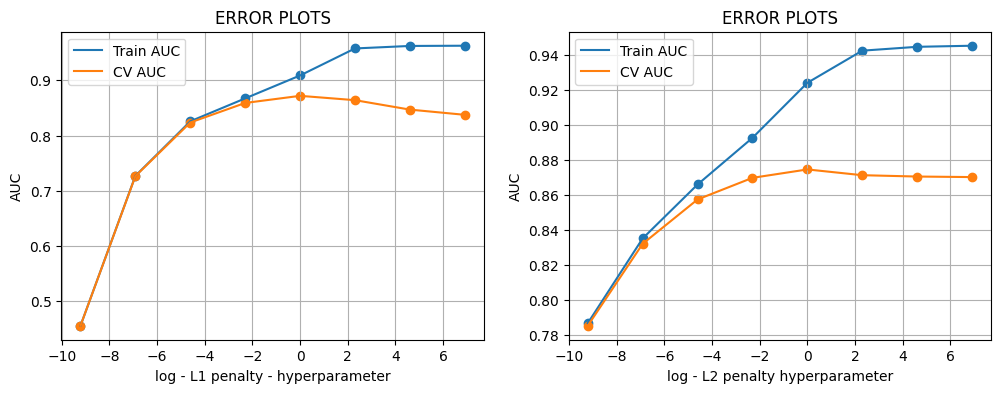

In [203]:
f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

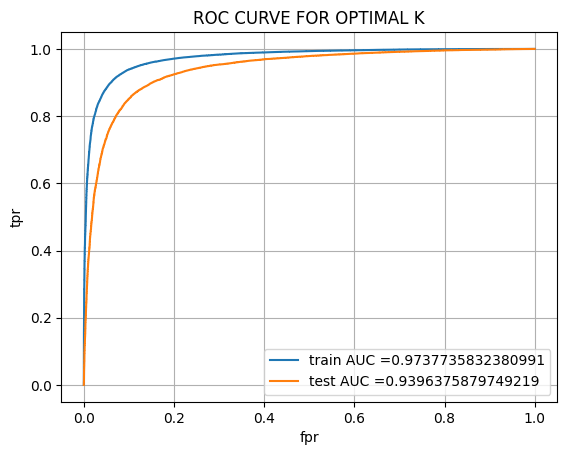

Area under train roc 0.9737735832380991
Area under test roc 0.9396375879749219


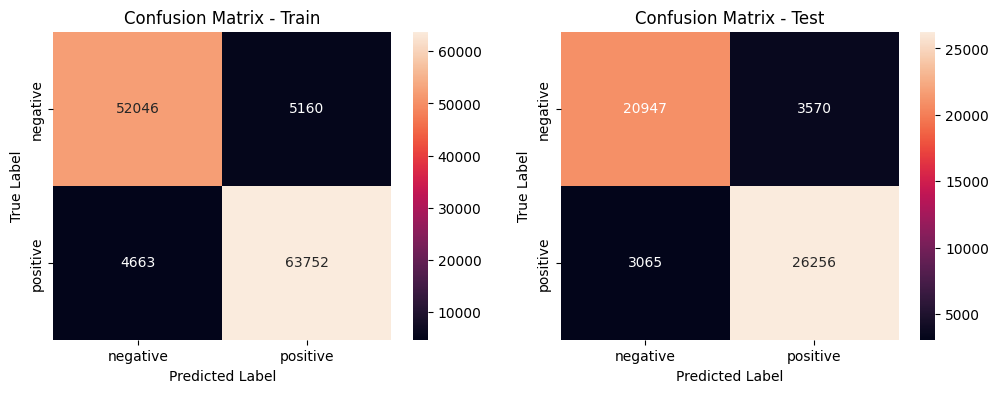

In [204]:
clf_l1_opt = LogisticRegression(penalty='l2', C=1,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_bow=auc(train_fpr, train_tpr)
test_roc_bow=auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_bow,y_train,X_test_bow,y_test)

### b) on TFIDF features

#### Using Grid search to use required parameters

In [205]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfidf,y_train)

print("Model with best parameters :\n",model.best_params_)

Model with best parameters :
 {'C': 10, 'penalty': 'l2'}


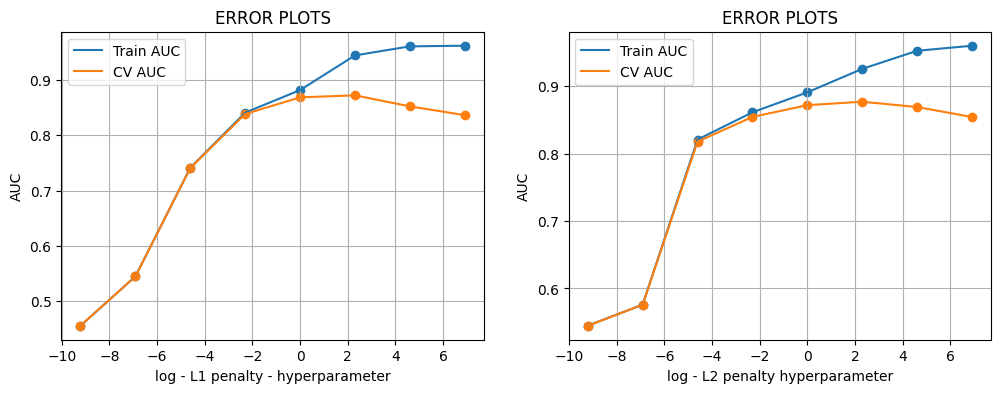

In [206]:
f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

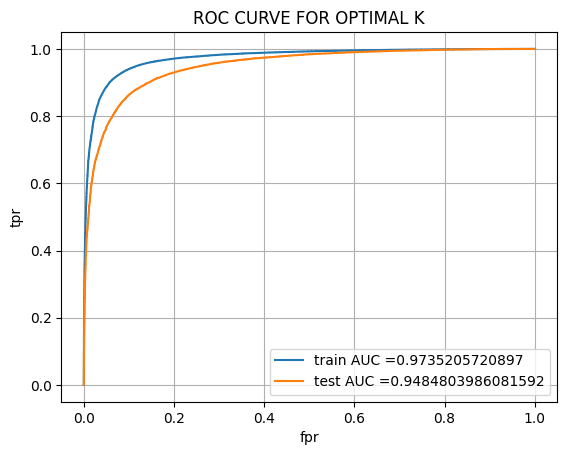

Area under train roc 0.9735205720897
Area under test roc 0.9484803986081592


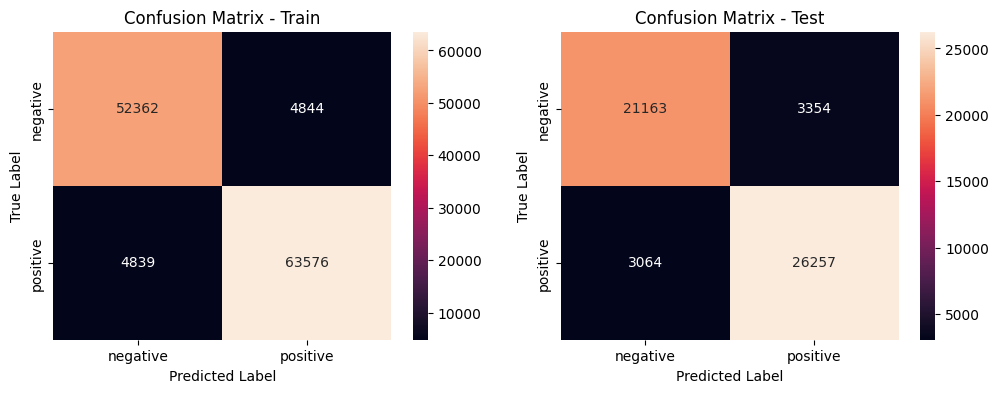

In [207]:
clf_l1_opt = LogisticRegression(penalty='l2', C=10,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tfidf=auc(train_fpr, train_tpr)
test_roc_tfidf=auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

### c) on Average Word2Vec

#### Using Grid search to use required parameters

In [208]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_avgw2v,y_train)

print("Model with best parameters :\n",model.best_params_)

Model with best parameters :
 {'C': 0.1, 'penalty': 'l2'}


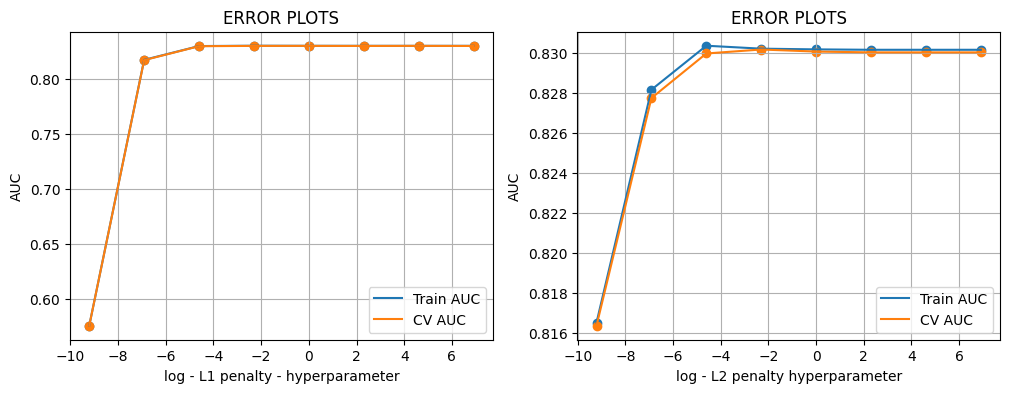

In [209]:
f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

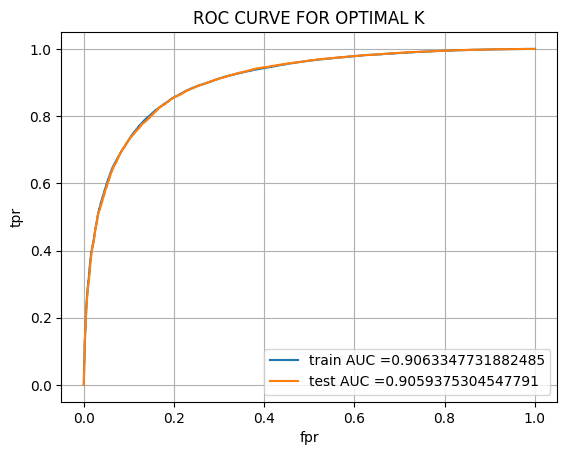

Area under train roc 0.9063347731882485
Area under test roc 0.9059375304547791


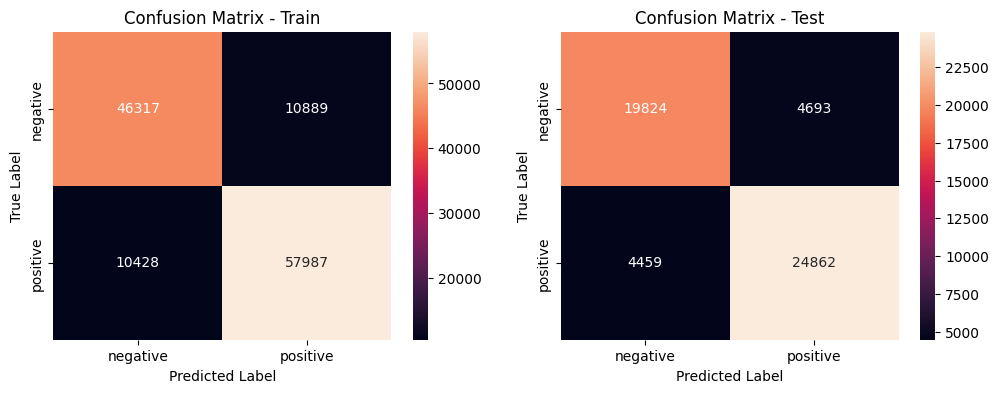

In [210]:
clf_l1_opt = LogisticRegression(penalty='l1', C=0.1,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_avgword2vec=auc(train_fpr, train_tpr)
test_roc_avgword2vec=auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

### d) on Average TFIDF Word2Vec

#### Using Grid search to use required parameters

In [211]:
penalty = ['l1','l2']
C = [0.0001,0.001,0.01,0.1,1,10,100,1000]

grid={"penalty":penalty,"C":C}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,return_train_score=True)
model.fit(X_train_tfw2v,y_train)

print("Model with best parameters :\n",model.best_params_)

Model with best parameters :
 {'C': 0.1, 'penalty': 'l1'}


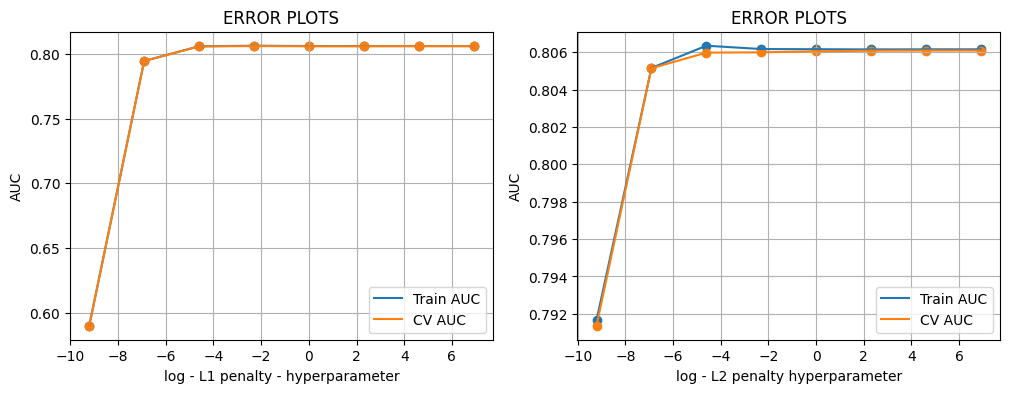

In [212]:
f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'log - L1 penalty - hyperparameter' if i ==0 else 'log - L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(C), train_auc, label='Train AUC')
  axes[i].plot(np.log(C), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(C), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(C), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

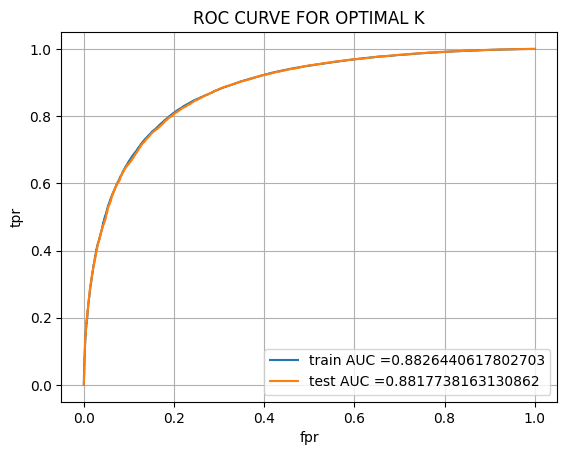

Area under train roc 0.8826440617802703
Area under test roc 0.8817738163130862


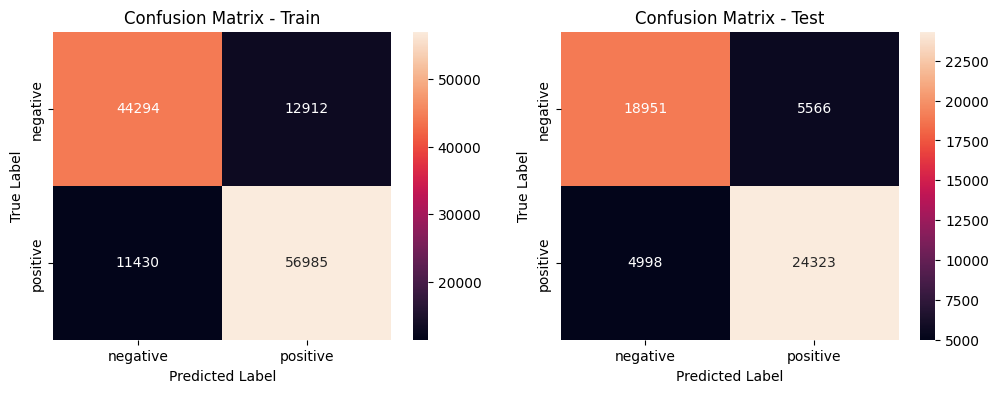

In [213]:
clf_l1_opt = LogisticRegression(penalty='l1', C=0.01,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tfidfword2vec=auc(train_fpr, train_tpr)
test_roc_tfidfword2vec=auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(clf_l1_opt,X_train_tfw2v,y_train,X_test_tfw2v,y_test)

### Observations and Conclusion on Logistic Regression

In [214]:
# !pip3 install https://pypi.python.org/packages/source/P/PrettyTable/prettytable-0.7.2.tar.bz2

In [215]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","regulariation", "Hyperparameter-C", "Train AUC", "Test AUC"]

z.add_row(["bow","Logistic regression","l2",1,train_roc_bow, test_roc_bow])
z.add_row(["tfidf","Logistic regression","l2",10,train_roc_tfidf,test_roc_tfidf])    
z.add_row(["avg-word2vec","Logistic regression","l1",0.1,train_roc_avgword2vec,test_roc_avgword2vec])
z.add_row(["tfidf-word2vec","Logistic regression","l1",0.01,train_roc_tfidfword2vec,test_roc_tfidfword2vec])

print(z)

+----------------+---------------------+---------------+------------------+--------------------+--------------------+
|     Vector     |      Algorithm      | regulariation | Hyperparameter-C |     Train AUC      |      Test AUC      |
+----------------+---------------------+---------------+------------------+--------------------+--------------------+
|      bow       | Logistic regression |       l2      |        1         | 0.9737735832380991 | 0.9396375879749219 |
|     tfidf      | Logistic regression |       l2      |        10        |  0.9735205720897   | 0.9484803986081592 |
|  avg-word2vec  | Logistic regression |       l1      |       0.1        | 0.9063347731882485 | 0.9059375304547791 |
| tfidf-word2vec | Logistic regression |       l1      |       0.01       | 0.8826440617802703 | 0.8817738163130862 |
+----------------+---------------------+---------------+------------------+--------------------+--------------------+


## 2. SVM

## 2.1. Linear SVC

### a) on BOW 

#### Using Grid search to use required parameters

In [216]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

Alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']
model = LinearSVC()
parameters = {'C': Alpha, 'penalty': penalty}
grid_search = GridSearchCV(model, param_grid=parameters, n_jobs=-1, scoring='roc_auc', cv=5, return_train_score=True)
grid_search.fit(X_train_bow, y_train)
print("Model with best parameters:\n", grid_search.best_params_)


Model with best parameters:
 {'C': 0.1, 'penalty': 'l2'}


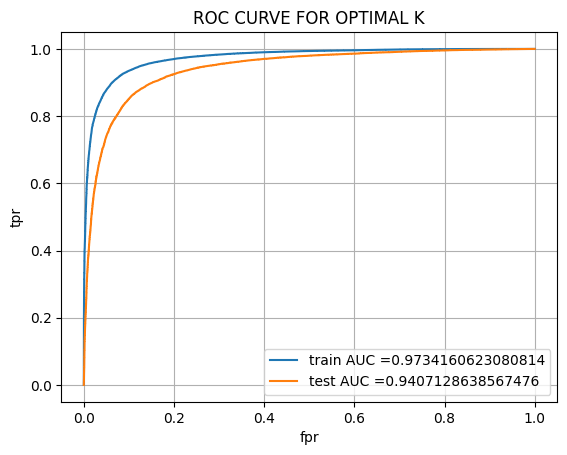

Area under train roc 0.9734160623080814
Area under test roc 0.9407128638567476


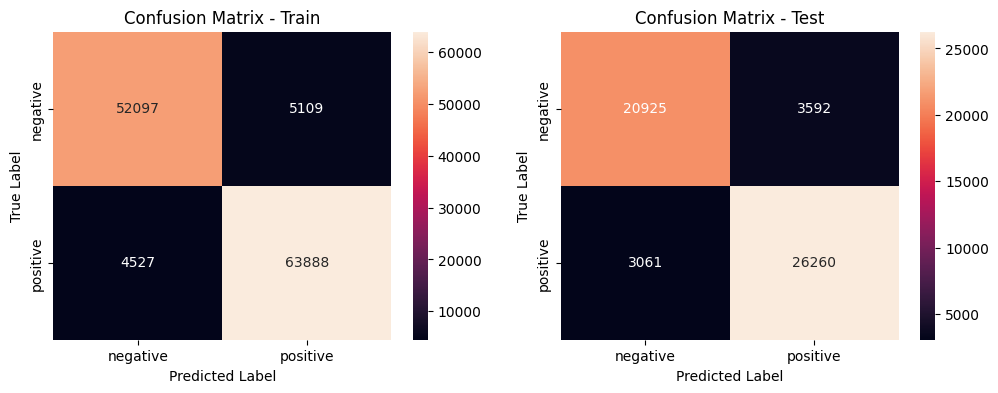

In [217]:
svm_opt = LinearSVC(penalty = 'l2', C=0.1)
svm_opt.fit(X_train_bow, y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_bow)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:, 1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_bowL = auc(train_fpr, train_tpr)
test_roc_bowL = auc(test_fpr, test_tpr)

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt, X_train_bow, y_train, X_test_bow, y_test)


### b) on TFIDF features

#### Using Grid search to use required parameters

In [218]:
Alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']

# Using LinearSVC
svc_opt = LinearSVC()
parameters_svc = {'C': Alpha, 'penalty': penalty}
model_svc = GridSearchCV(svc_opt, param_grid=parameters_svc, n_jobs=-1, scoring='roc_auc', cv=5, return_train_score=True)
model_svc.fit(X_train_tfidf, y_train)
print("Model with best parameters:\n", model_svc.best_params_)


Model with best parameters:
 {'C': 1, 'penalty': 'l2'}


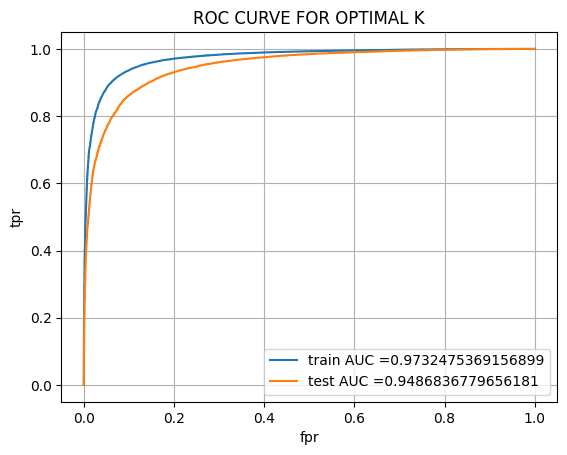

Area under train roc 0.9732475369156899
Area under test roc 0.9486836779656181


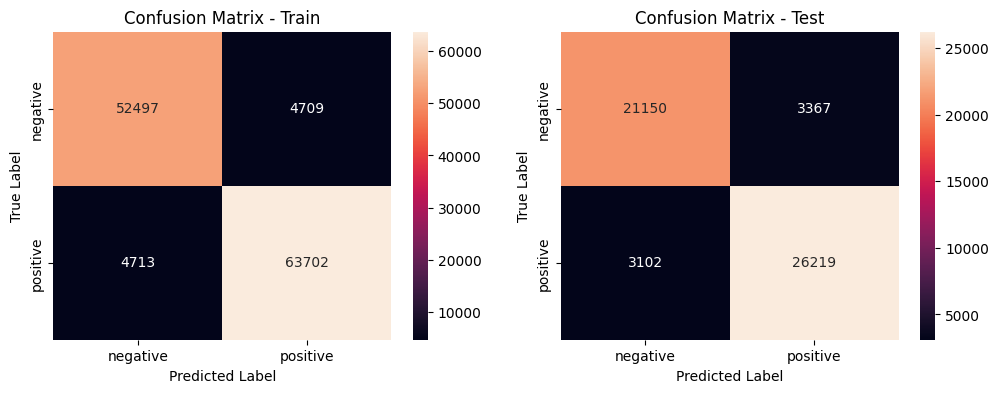

In [219]:
# Create and fit LinearSVC with best parameters
svm_opt = LinearSVC(C=1, penalty='l2')
svm_opt.fit(X_train_tfidf, y_train)

# Create calibrated classifier for probability estimation
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est.fit(X_train_tfidf, y_train)

# Calculate ROC curves and AUC scores for train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfidf)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:, 1])

# Plot ROC curves
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tdidfL = auc(train_fpr, train_tpr)
test_roc_tfidfL = auc(test_fpr, test_tpr)

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(svm_opt, X_train_tfidf, y_train, X_test_tfidf, y_test)


### c) on Average Word2Vec

#### Using Grid search to use required parameters

In [220]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']

# Create and fit GridSearchCV with LinearSVC
parameters = {'C': Alpha, 'penalty': penalty}
model = GridSearchCV(LinearSVC(), param_grid=parameters, n_jobs=-1, scoring='roc_auc', cv=5, return_train_score=True)
model.fit(X_train_avgw2v, y_train)
print("Model with best parameters:\n", model.best_params_)

Model with best parameters:
 {'C': 0.01, 'penalty': 'l2'}


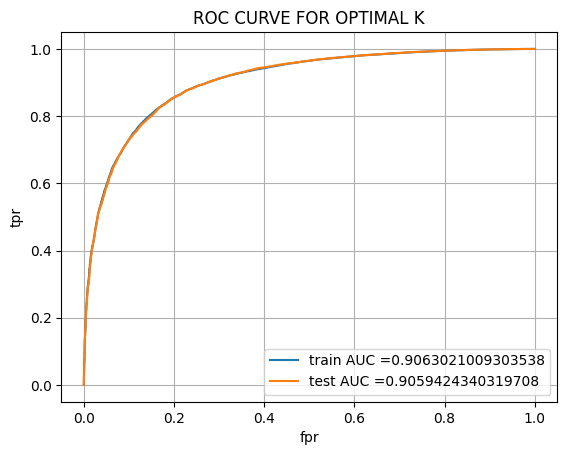

Area under train roc 0.9063021009303538
Area under test roc 0.9059424340319708


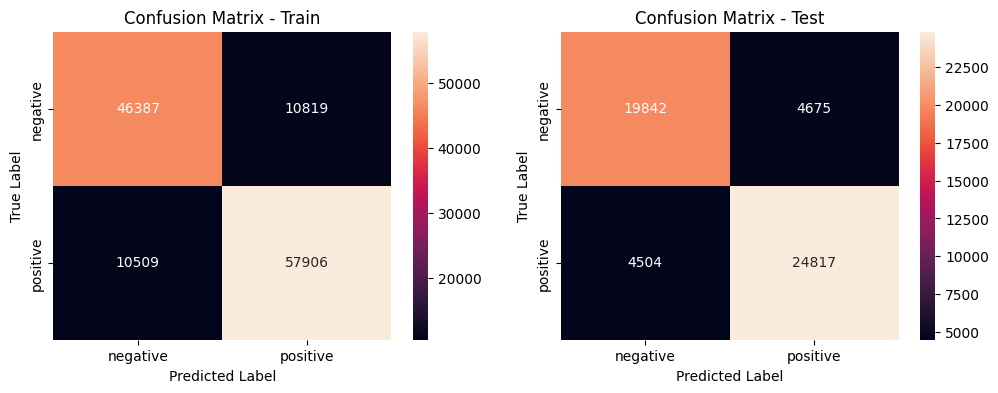

In [221]:
# Create and fit LinearSVC with best parameters
svm_opt = LinearSVC(C=1, penalty='l2')
svm_opt.fit(X_train_avgw2v, y_train)

# Create calibrated classifier for probability estimation
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est.fit(X_train_avgw2v, y_train)

# Calculate ROC curves and AUC scores for train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_avgw2v)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:, 1])

# Plot ROC curves
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_avgw2vL = auc(train_fpr, train_tpr)
test_roc_avgw2vL = auc(test_fpr, test_tpr)

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(svm_opt, X_train_avgw2v, y_train, X_test_avgw2v, y_test)

### d) on Average TFIDF Word2Vec

#### Using Grid search to use required parameters

In [224]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1', 'l2']

# Create and fit GridSearchCV with LinearSVC
parameters = {'C': Alpha, 'penalty': penalty}
model = GridSearchCV(LinearSVC(), param_grid=parameters, n_jobs=-1, scoring='roc_auc', cv=5, return_train_score=True)
model.fit(X_train_tfw2v, y_train)
print("Model with best parameters:\n", model.best_params_)

Model with best parameters:
 {'C': 1, 'penalty': 'l2'}


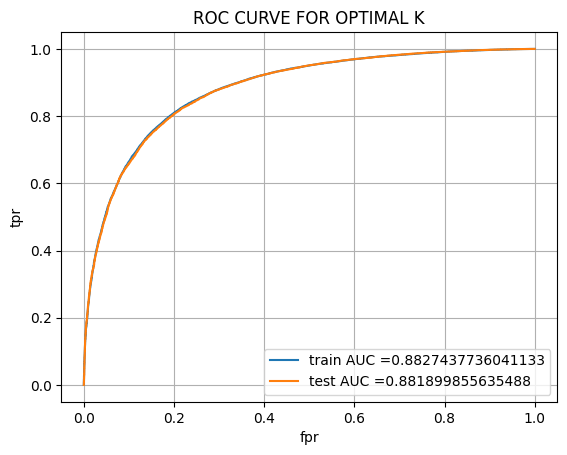

Area under train roc 0.8827437736041133
Area under test roc 0.881899855635488


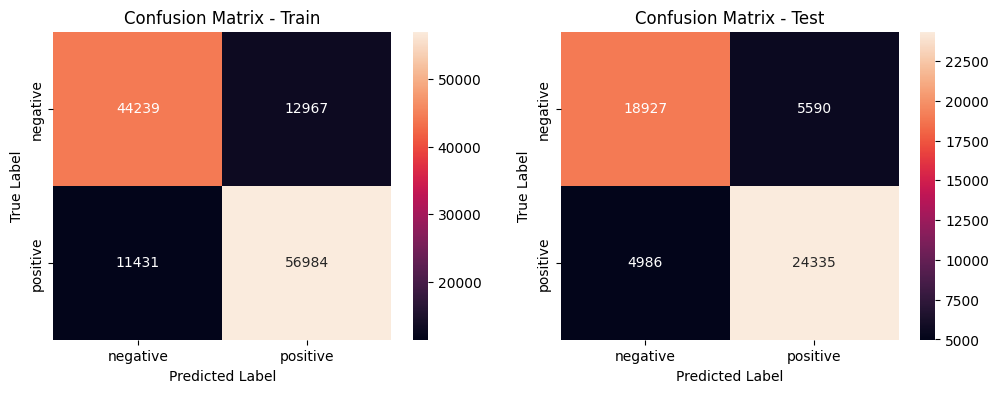

In [225]:
svm_opt = LinearSVC(C=0.1, penalty='l2')
svm_opt.fit(X_train_tfw2v, y_train)

# Create calibrated classifier for probability estimation
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est.fit(X_train_tfw2v, y_train)

# Calculate ROC curves and AUC scores for train and test data
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfw2v)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:, 1])

# Plot ROC curves
plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC =" + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC =" + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tfw2vL = auc(train_fpr, train_tpr)
test_roc_tfw2vL = auc(test_fpr, test_tpr)

# Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(svm_opt, X_train_tfw2v, y_train, X_test_tfw2v, y_test)

## 2.2. SVM RBF Kernel Classifier

RBF kernel SVM is very computationaly expensive.So we will try with 20k datapoints

In [226]:
df = amazon_data.sample(20000,random_state=100)
df.shape

(20000, 5)

In [227]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df['processed_string']
y = df['target']
X_tr,X_test,y_tr,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)

### a) SVM RBF On BOW

In [228]:
bow = CountVectorizer(min_df=10,max_features=500)
bow.fit(X_tr)
X_train_bow = bow.transform(X_tr)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (14000, 500)
shape of X_test_bow is (6000, 500)


#### Using Grid search to use required parameters

In [229]:
#from sklearn.svm import SVC
#c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#parameters = {'C':c,'gamma': Gamma}
#model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5,return_train_score=True)
#model.fit(X_train_bow,y_tr)
#print("Model with best parameters :\n",model.best_params_)

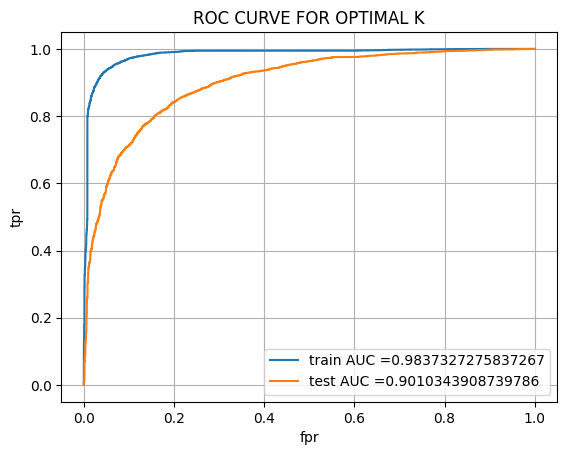

Area under train roc 0.9837327275837267
Area under test roc 0.9010343908739786


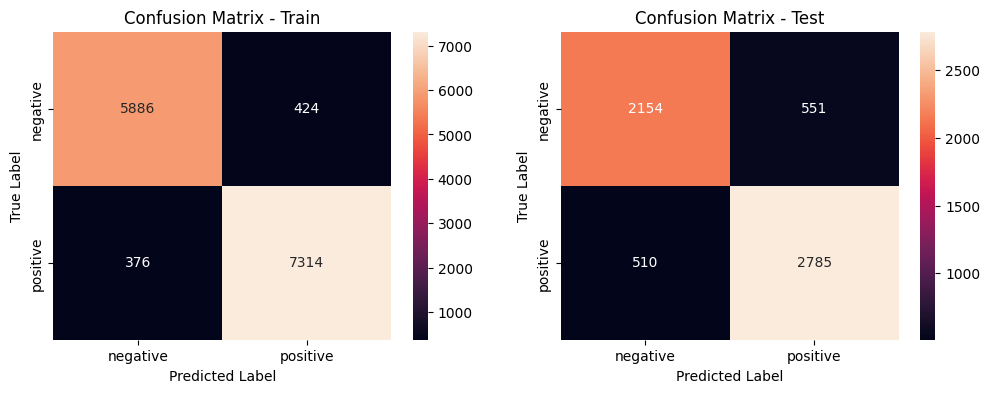

In [230]:
best_est = SVC(C= 10, gamma= 0.01,probability=True)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_bowK = auc(train_fpr, train_tpr)
test_roc_bowK = auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_tr,X_test_bow,y_test)

### b) SVM RBF On TFIDF

In [231]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_test_tfidf = vectorizer.transform(X_test)

print('shape of X_train_tfidf is {}'.format(X_train_tfidf.get_shape()))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.get_shape()))

shape of X_train_tfidf is (14000, 500)
shape of X_test_tfidf is (6000, 500)


#### Using Grid search to use required parameters

In [232]:
#from sklearn.svm import SVC
#c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#parameters = {'C':c,'gamma': Gamma}
#model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
#model.fit(X_train_tfidf,y_tr)
#print("Model with best parameters :\n",model.best_params_)

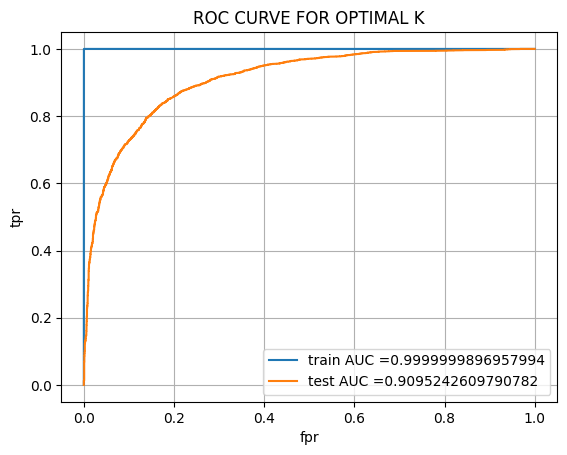

Area under train roc 0.9999999896957994
Area under test roc 0.9095242609790782


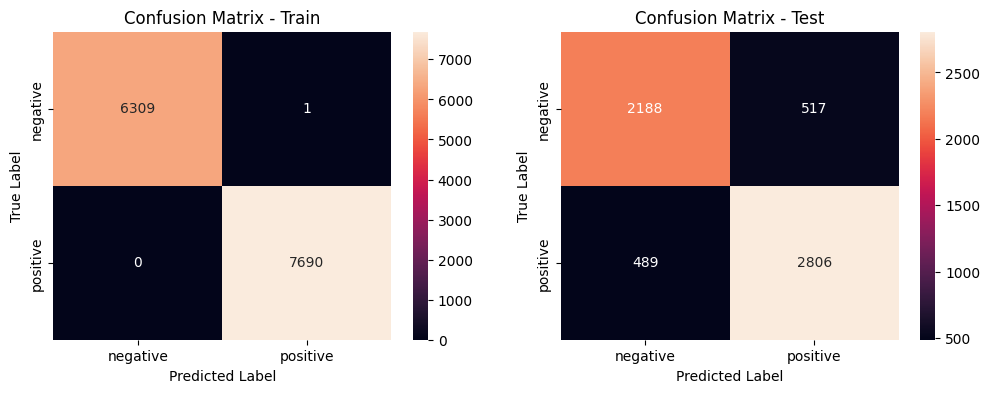

In [233]:
from sklearn.svm import SVC
best_est = SVC(C= 10, gamma= 1, probability=True)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tfidfK = auc(train_fpr, train_tpr)
test_roc_tfidfK = auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_tr,X_test_tfidf,y_test)

### c) SVM RBF ON Avg Word2Vec

In [234]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values

train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,vector_size=50, workers=4)

w2v_words_train = list(w2v_model_train.wv.index_to_key)


# compute average word2vec for each review for train data.
preprocessed_reviews = X_tr.values
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 14000/14000 [00:08<00:00, 1579.19it/s]

14000
50


In [235]:
# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

X_train_avgw2v = sent_vectors_train
X_test_avgw2v = sent_vectors_test

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1570.77it/s]

6000
50


#### Using Grid search to use required parameters

In [236]:
#from sklearn.svm import SVC
#c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#parameters = {'C':c,'gamma': Gamma}
#model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
#model.fit(X_train_avgw2v,y_tr)
#print("Model with best parameters :\n",model.best_params_)

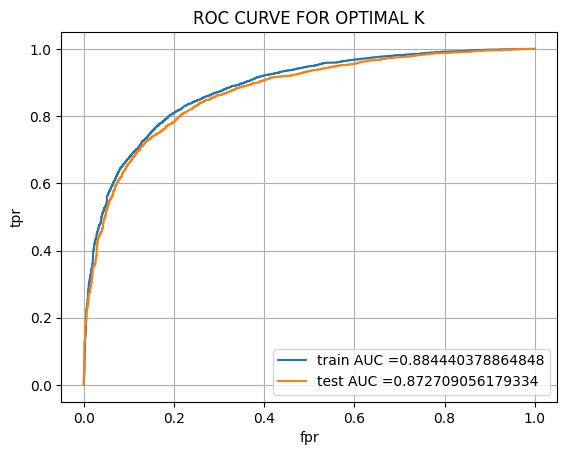

Area under train roc 0.884440378864848
Area under test roc 0.872709056179334


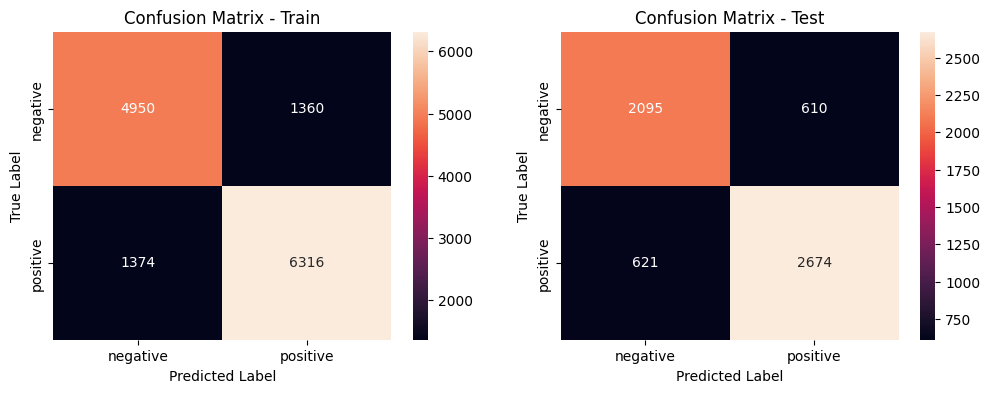

In [237]:
best_est = SVC(C= 100, gamma= 0.01,probability=True)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_avgw2vK = auc(train_fpr, train_tpr)
test_roc_avgw2vK = auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(best_est,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

### d) SVM RBF On TFIDF Word2Vec

In [238]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values

train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

w2v_model_train=Word2Vec(train_sentance,min_count=5,vector_size=50, workers=4)

w2v_words = list(w2v_model_train.wv.index_to_key)
#####################################################################
tfidf = TfidfVectorizer()
tfidf.fit(X_tr)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))


######################################################################

test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))


X_train_tfw2v = sent_vectors_train
X_test_tfw2v = sent_vectors_test

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [01:49<00:00, 128.17it/s]


14000


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:46<00:00, 128.75it/s]

6000


#### Using Grid search to use required parameters

In [239]:
#from sklearn.svm import SVC
#c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
#parameters = {'C':c,'gamma': Gamma}
#model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
#model.fit(X_train_tfw2v,y_tr)
#print("Model with best parameters :\n",model.best_params_)

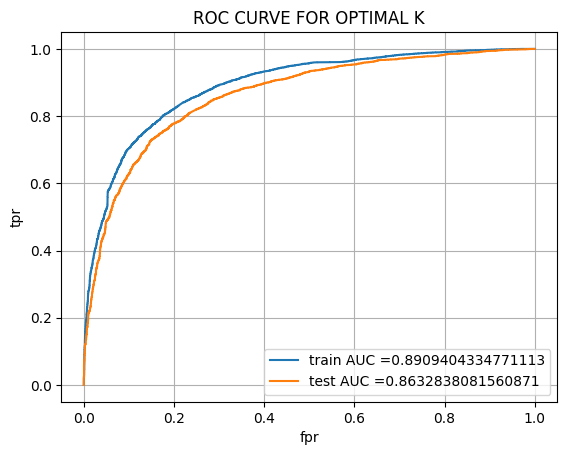

Area under train roc 0.8909404334771113
Area under test roc 0.8632838081560871


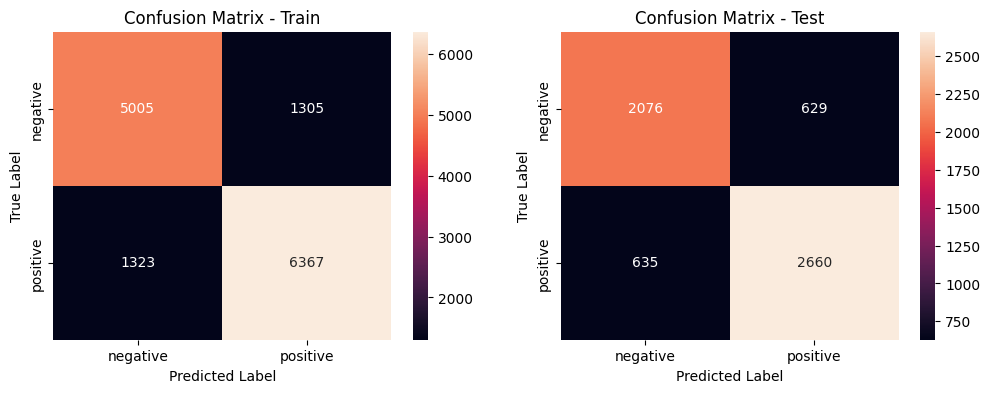

In [240]:
best_est = SVC(C= 1000, gamma= 0.01,probability=True)
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

train_roc_tfw2v =  auc(train_fpr, train_tpr)
test_roc_tfw2v = auc(test_fpr, test_tpr)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)

### Observations and Conclusion on SVM

In [243]:
z = PrettyTable()

z.field_names = ["Vector","Algorithm","kernel","penalty","Hyperparam-alpha","Hyperparam-C","gamma","Train AUC", "Test AUC"]

z.add_row(["bow","SVM","linear","l2",0.1,"-","-",train_roc_bowL,test_roc_bowL])
z.add_row(["tfidf","SVM","linear","l2",1,"-","-",train_roc_tdidfL,train_roc_tdidfL])
z.add_row(["avg-w2v","SVM","linear","l2",1,"-","-",train_roc_avgw2vL,test_roc_avgw2vL])
z.add_row(["tfidf-w2v","SVM","linear","l2",0.1,"-","-",train_roc_tfw2vL,test_roc_tfw2vL])
z.add_row(["bow","SVM","RBF","-","-",10,0.01,train_roc_bowK,test_roc_bowK])
z.add_row(["tfidf","SVM","RBF","-","-",10,1,train_roc_tfidfK,test_roc_tfidfK])
z.add_row(["avg-w2v","SVM","RBF","-","-",100,0.01,train_roc_avgw2vK,test_roc_avgw2vK])
z.add_row(["tfidf-w2v","SVM","RBF","-","-",1000,0.01,train_roc_tfw2v,test_roc_tfw2v])
print(z)


+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|   Vector  | Algorithm | kernel | penalty | Hyperparam-alpha | Hyperparam-C | gamma |     Train AUC      |      Test AUC      |
+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|    bow    |    SVM    | linear |    l2   |       0.1        |      -       |   -   | 0.9734160623080814 | 0.9407128638567476 |
|   tfidf   |    SVM    | linear |    l2   |        1         |      -       |   -   | 0.9732475369156899 | 0.9732475369156899 |
|  avg-w2v  |    SVM    | linear |    l2   |        1         |      -       |   -   | 0.9063021009303538 | 0.9059424340319708 |
| tfidf-w2v |    SVM    | linear |    l2   |       0.1        |      -       |   -   | 0.8827437736041133 | 0.881899855635488  |
|    bow    |    SVM    |  RBF   |    -    |        -         |      10      |  0.01 | 0.98373272

- SVM performs good with our text data.
- Some of the linear SVM models are slightly overfitting.
- As RBF kernels are computationally expensive we only used 20000 points. Eventhen the model is performing well. Eventhough our RBF based models are overfitting, it can be overcome by using more train data.
- Here out of all our model we have a more generalized model with linear SVM on average word2vec vectors.